In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Mazda.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_121,Seri_2,Seri_3,...,Model_2.0 TE,Model_2.0i SKYACTIVE-G Power Sense,Model_MX-5 1.5,Model_MX-5 2.0,Model_RX-8 1.3,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik
0,1420000,0.818182,1.750000,2.105769,-1.284644,0.0,0.0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,395000,-0.545455,0.083333,0.182692,-0.074906,NaN,NaN,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,370000,-0.545455,0.083333,0.182692,0.494382,5.0,0.0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,182000,-1.181818,0.555556,1.346154,0.599251,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,730000,0.272727,0.500000,-0.307692,-0.097378,1.0,0.0,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_15744\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,70025.619146,4.093683e+09,63981.897319,45053.481485


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:07:16,668] A new study created in memory with name: no-name-9ea99deb-7f1a-46f9-b099-5f654c5d7604
[I 2023-05-23 21:07:16,785] Trial 0 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.37977301249189555, 'max_depth': 14, 'min_child_weight': 294}. Best is trial 0 with value: 452206.7037063497.
[I 2023-05-23 21:07:16,796] Trial 2 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.43543964406955427, 'max_depth': 15, 'min_child_weight': 192}. Best is trial 0 with value: 452206.7037063497.
[I 2023-05-23 21:07:16,799] Trial 1 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.40982708590482103, 'max_depth': 13, 'min_child_weight': 189}. Best is trial 0 with value: 452206.7037063497.
[I 2023-05-23 21:07:16,813] Trial 4 finished with value: 452206.7037063497 and parameters: {'cols

[I 2023-05-23 21:07:17,763] Trial 30 finished with value: 209106.16706252593 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.12486876625775141, 'max_depth': 5, 'min_child_weight': 57}. Best is trial 30 with value: 209106.16706252593.
[I 2023-05-23 21:07:17,787] Trial 31 finished with value: 205497.93102414446 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.10578069023278172, 'max_depth': 5, 'min_child_weight': 49}. Best is trial 31 with value: 205497.93102414446.
[I 2023-05-23 21:07:17,873] Trial 32 finished with value: 265077.1538013549 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.08950635503486674, 'max_depth': 12, 'min_child_weight': 53}. Best is trial 31 with value: 205497.93102414446.
[I 2023-05-23 21:07:17,874] Trial 33 finished with value: 197015.3625409662 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.13680432892364722, 'max_depth': 13, 'min_child_wei

[I 2023-05-23 21:07:19,267] Trial 61 finished with value: 94216.3221445003 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.36527260267801265, 'max_depth': 14, 'min_child_weight': 21}. Best is trial 49 with value: 66416.67187820266.
[I 2023-05-23 21:07:19,326] Trial 60 finished with value: 92648.98072978157 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.36539892470515684, 'max_depth': 14, 'min_child_weight': 22}. Best is trial 49 with value: 66416.67187820266.
[I 2023-05-23 21:07:19,409] Trial 62 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3452894140522914, 'max_depth': 12, 'min_child_weight': 173}. Best is trial 49 with value: 66416.67187820266.
[I 2023-05-23 21:07:19,428] Trial 64 finished with value: 452206.7037063497 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.30898236346687535, 'max_depth': 12, 'min_child_weight'

[I 2023-05-23 21:07:20,719] Trial 90 finished with value: 245021.44957245022 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.41968944125585556, 'max_depth': 15, 'min_child_weight': 62}. Best is trial 49 with value: 66416.67187820266.
[I 2023-05-23 21:07:20,720] Trial 91 finished with value: 245027.66090897666 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4182968189143238, 'max_depth': 15, 'min_child_weight': 63}. Best is trial 49 with value: 66416.67187820266.
[I 2023-05-23 21:07:20,835] Trial 92 finished with value: 115149.44798452579 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4244708327080286, 'max_depth': 15, 'min_child_weight': 37}. Best is trial 49 with value: 66416.67187820266.
[I 2023-05-23 21:07:20,926] Trial 93 finished with value: 245068.2227096982 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4101510648065143, 'max_depth': 14, 'min_child_weight

[I 2023-05-23 21:07:22,257] Trial 119 finished with value: 79283.62724658307 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3017709821454249, 'max_depth': 14, 'min_child_weight': 1}. Best is trial 95 with value: 65979.40357810713.
[I 2023-05-23 21:07:22,259] Trial 121 finished with value: 97998.50036507241 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.21479581729125471, 'max_depth': 14, 'min_child_weight': 17}. Best is trial 95 with value: 65979.40357810713.
[I 2023-05-23 21:07:22,293] Trial 122 finished with value: 88552.10375424684 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.29277602659692414, 'max_depth': 14, 'min_child_weight': 18}. Best is trial 95 with value: 65979.40357810713.
[I 2023-05-23 21:07:22,333] Trial 123 finished with value: 88850.70117970985 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.28804436938257844, 'max_depth': 15, 'min_child_weig

[I 2023-05-23 21:07:23,872] Trial 151 finished with value: 90187.41103509064 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.39016219324643187, 'max_depth': 12, 'min_child_weight': 27}. Best is trial 140 with value: 52473.51983267218.
[I 2023-05-23 21:07:23,873] Trial 153 finished with value: 89301.5801488783 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4070877256641371, 'max_depth': 12, 'min_child_weight': 27}. Best is trial 140 with value: 52473.51983267218.
[I 2023-05-23 21:07:23,873] Trial 150 finished with value: 92252.75194868004 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.48750304292923285, 'max_depth': 12, 'min_child_weight': 27}. Best is trial 140 with value: 52473.51983267218.
[I 2023-05-23 21:07:23,875] Trial 155 finished with value: 88128.33179674175 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.39141762195378593, 'max_depth': 12, 'min_child_w

[I 2023-05-23 21:07:25,418] Trial 180 finished with value: 104808.64403063348 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.1886036230899794, 'max_depth': 6, 'min_child_weight': 18}. Best is trial 170 with value: 49462.63466231053.
[I 2023-05-23 21:07:25,507] Trial 181 finished with value: 405367.9975839823 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.011870998939351342, 'max_depth': 6, 'min_child_weight': 17}. Best is trial 170 with value: 49462.63466231053.
[I 2023-05-23 21:07:25,614] Trial 183 finished with value: 74762.02824205381 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.36072927428514484, 'max_depth': 6, 'min_child_weight': 17}. Best is trial 170 with value: 49462.63466231053.
[I 2023-05-23 21:07:25,621] Trial 182 finished with value: 68823.29047011434 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.34058618100995147, 'max_depth': 6, 'min_child_we

[I 2023-05-23 21:07:27,182] Trial 210 finished with value: 71396.24628409963 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.23305557432674134, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 170 with value: 49462.63466231053.
[I 2023-05-23 21:07:27,235] Trial 211 finished with value: 68586.45351812862 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.2351056529448837, 'max_depth': 6, 'min_child_weight': 5}. Best is trial 170 with value: 49462.63466231053.
[I 2023-05-23 21:07:27,296] Trial 212 finished with value: 67350.39352919837 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.22899260080525038, 'max_depth': 6, 'min_child_weight': 6}. Best is trial 170 with value: 49462.63466231053.
[I 2023-05-23 21:07:27,422] Trial 213 finished with value: 50306.05672181219 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3671912734746239, 'max_depth': 7, 'min_child_weight':

[I 2023-05-23 21:07:29,046] Trial 238 finished with value: 447908.36904519435 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.0010412266964549986, 'max_depth': 8, 'min_child_weight': 14}. Best is trial 229 with value: 49418.22639097305.
[I 2023-05-23 21:07:29,138] Trial 241 finished with value: 66267.89424368426 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.42356273683275797, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 229 with value: 49418.22639097305.
[I 2023-05-23 21:07:29,191] Trial 242 finished with value: 64183.804317601585 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4216844154617051, 'max_depth': 8, 'min_child_weight': 14}. Best is trial 229 with value: 49418.22639097305.
[I 2023-05-23 21:07:29,279] Trial 243 finished with value: 60953.9588730561 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.4231602343658412, 'max_depth': 8, 'min_child_we

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 49418.2264
Best params:
	colsample_bytree: 0.5
	subsample: 1.0
	learning_rate: 0.37517875872090833
	max_depth: 8
	min_child_weight: 6


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.3],
                  "max_depth": [8,13],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.5],
               'subsample': [1],
               'min_child_weight': [6]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 500, 'subsample': 1}
{'TestDeger': 86456.95294197337, 'MSE': 3299406966.375575, 'RMSE': 57440.46453829891, 'MAE': 43973.5625}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.94206810697067

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.90363803931755

In [17]:
marka_model = joblib.dump(grid_final_model, "Mazda.pkl")

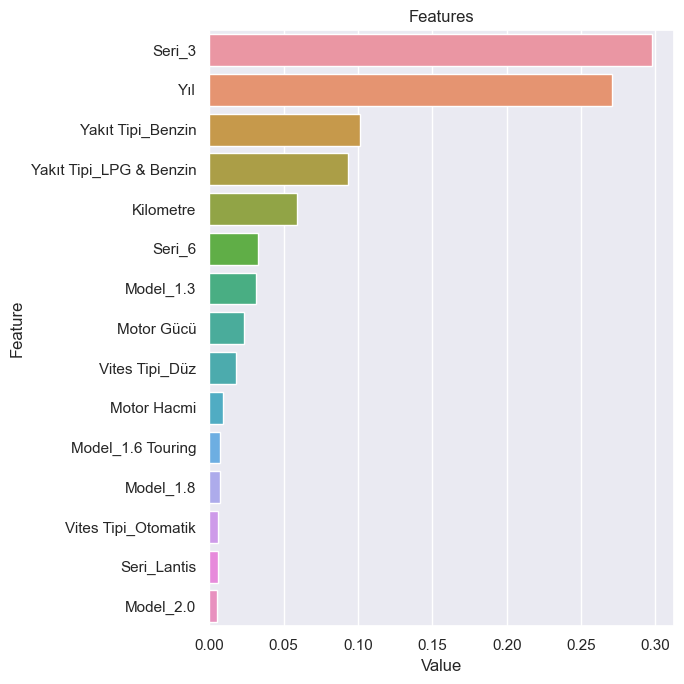

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)